__Statistical Learning in High Dimension__
<br>_Professor: M. Hebiri_
<br>_Students: M. Berezov, V. Oliinyk_
### TP2. Projection estimation
_In this practical session we are studying projection estimation and the role the smoothing parameter N (the number of the first functions of the basis in our functional space) plays._

#### Exercise 1. Fourier
1.1 _Data simulation_
<br> We simulate a sample of 100 couples of independent variables $(X_i, Y_i), i = 1,...,n$, where
i.i.d. $X_i$ is coming from standard uniform distribution, and $Y_i$: $$Y_i = f(X_i) + \sigma \xi_i,$$ where $f(x) = x^2 2^{x-1}-(x-0.5)^3 sin(10x), \sigma = 0.2, \xi_i  \sim N(0,1)$, i.i.d.
<br>We observe $X_i$ and $Y_i, i=1,...,n$

In [34]:
import numpy as np
n = 100
X = np.random.uniform(0, 1, 100)
def f(x):
    return ((x**2)*(2**(x-1))-(x-0.5)**3)*np.sin(10*x)
sigma = 0.2
Ksi = np.random.normal(0, 1, 100)
Y = f(X) + sigma*Ksi

Let's take a look at the observations (in blue dots) and the underlying $f(x)$ function (red line).

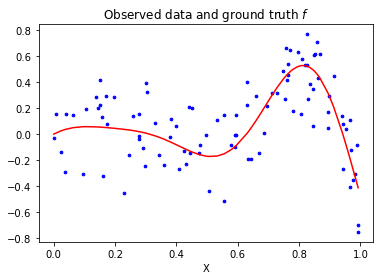

In [35]:
import matplotlib.pyplot as plt
ind_ord = X.argsort()
X = X[ind_ord]
Y = Y[ind_ord]
plt.plot(X, Y, 'bo', ms=2.7)
plt.plot(X, f(X), '-r')
plt.title("Observed data and ground truth $f$")
plt.xlabel("X")
plt.show()

<br> We can think of $Y$ as a noisy version of the function $f(X)$.

<br>
Our goal is to build a projection estimator of the function $f$ using the observed data $\{X_i, Y_i\}, i=1,...,n$. 
<br>We will build first $N$ functions from an orthonormal Fourier basis $\{\varphi_{j}\}_{j=1}^{N}$ and approximate $f$ by its projection on their linear span: $\sum_{j=1}^{N}\theta_j\varphi_j$. We will replace coefficients $\theta_j$ by their estimators. 

<br> _Fourier basis_
<br> An orthonormal basis in $L_2 [0,1]$ defined by
$$ \varphi_1(x) \equiv 1,$$
$$ \varphi_{2j}(x) = \sqrt{2}cos(2\pi jx)$$
$$ \varphi_{2j+1}(x) = \sqrt{2}cos(2\pi jx)$$ 
$$ j = 1, 2,...$$
Let's look at the first 5 funcitons of this basis. 

In [36]:
# Fourier basis
def phi (j, x):
    if j==1:
        return np.ones(len(x))
    elif (j%2==0):
        return np.sqrt(2)*np.cos(np.pi*j*x)
    else:
        return np.sqrt(2)*np.sin(np.pi*(j-1)*x)

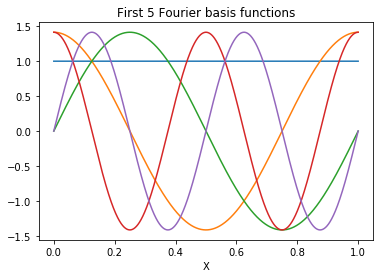

In [37]:
grid_x = np.linspace(0, 1, num = 10**4)
for j in np.arange(5)+1:
    plt.plot(grid_x, phi(j, grid_x), '-')
plt.title("First 5 Fourier basis functions")
plt.xlabel("X")
plt.show()

Functions of Fourier basis are periodic, and this implies that it would be a good idea to project non-linear periodic functions on such a basis.

As menitoned, above, we buid a projection estimator in the following way: 
$$ \hat{f}_{n, N}(x) = \sum_{j=1}^{N}\hat{\theta_j}\varphi_j(x),$$
where $$\hat{\theta_j}=\frac{1}{n}\sum_{i=1}^{n}Y_i\varphi_j(X_i)$$
Notice that $n$ is a size of our sample and $N$ is a number of first functions in the Fourier basis, $n > N$.
<br> We also notice that $X_i$ is uniformly distributed over [0,1]; hence, as discussed during the lecture, the true coefficients $\theta$ are well approximated by $\hat{\theta}$.

<br> Below, we plot the obseved $\{X_i, Y_i\}$, ground-truth function $f$ and its projection estimator $\hat{f}_N$ for different values of smoothing parameter $N = \{5, 10, 15, 20, 30, 50, 70\}$.

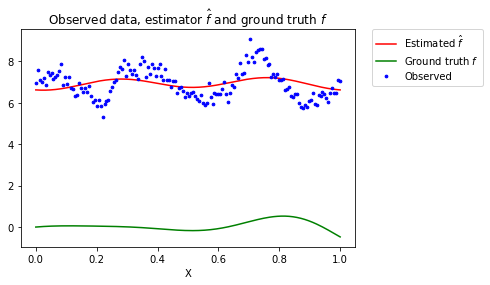

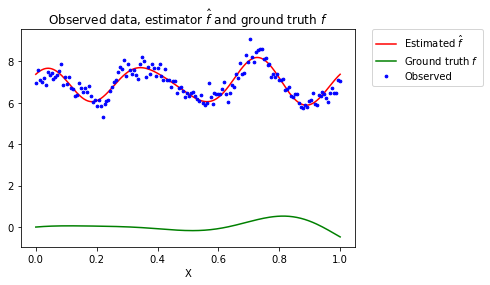

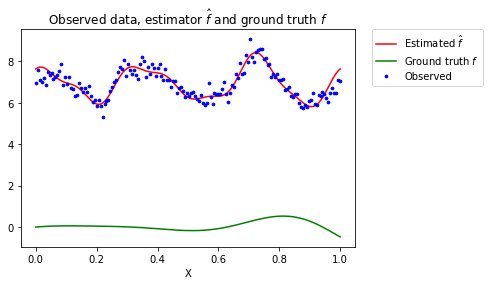

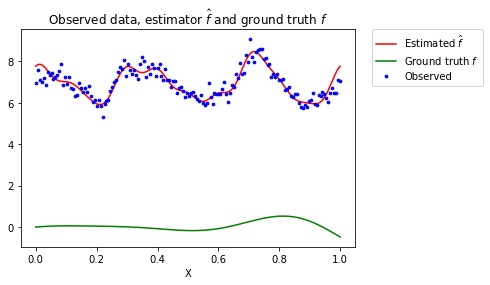

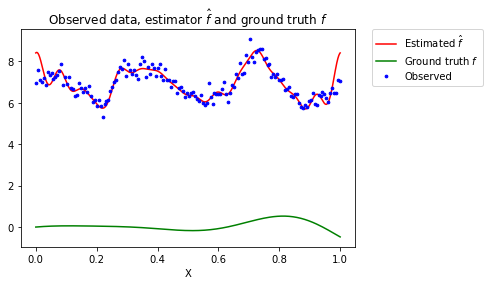

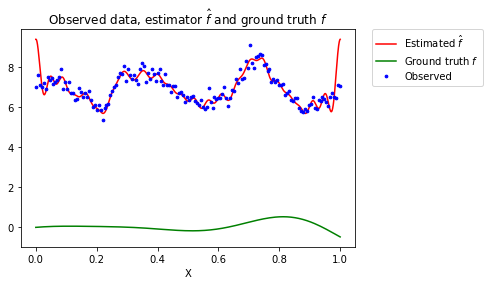

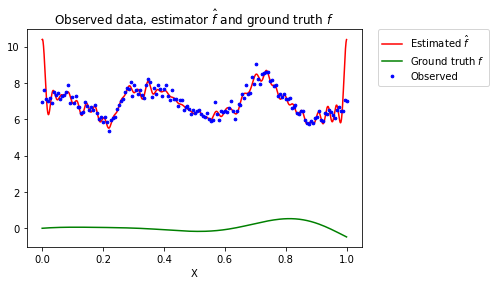

In [83]:
Ns = [5, 10, 15, 20, 30, 50, 70]
# Projection estimator
# Calculate the Fourier coefficients:
def theta(X, Y, j):
    Theta = Y*phi(j, X)
    return np.mean(Theta)
# Build projection estimator:
def f_hat(N, x, X, Y):
    F = np.array([theta(X, Y, j)*phi(j, x) for j in np.arange(N)+1])
    return np.sum(F, axis=0)
# Plot projection estimators, observation and true f for different N
for N in Ns:
    fN_hat = f_hat(N, grid_x, X, Y)
    line1, = plt.plot(grid_x, fN_hat,'-r',label="Estimated $\hat{f}$")
    line2, = plt.plot(X, f(X), '-g',label="Ground truth $f$")
    line3, = plt.plot(X, Y, 'bo', ms=2.7,label="Observed")
    plt.title("Observed data, estimator $\hat{f}$ and ground truth $f$")
    plt.xlabel("X")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

As the plots above show, it is a bad idea to use more than 20 first functions of the basis in the estimator $\hat{f}$. In this case, the function $\hat{f}$ becomes very oscillating leading to strong overfitting.
<br> By eye, we estimate the optimal number of basis functions to be around 5-10. 
<br> We want to use a more systematic approach, namely, cross-validation to estimate the optimal number $N$.

<br> _Cross-validation_
<br> We split sample $\{X_i, Y_i\}$ into $V$ folds (nearly equally sized), and for different values of $N$ we calculate _cross-validation error_, $\epsilon_{CV}(N)$. 
<br>For every fold $B_v$ we train the estimator on the resting data, getting $\hat{f}^{-v}(x)$ and test it on this fold, calculating $\epsilon_v=\frac{1}{\#(B_v)}\sum_{i=1}^{n}(\hat{f}^{-v}(X_i)-Y_i)^2$. Averaging errors on all folds, we get cross-validation error: $\epsilon_{CV}(N)=\frac{1}{V}\sum_{v=1}{V}\epsilon_v$. We choose the model delivering the minimal cross-validation error.

<br> We have chosen the number of folds to be 10. This is a classical practice.

In [84]:
# Calculate error on fold B_v
def err_Bv(N, v, V, X, Y):
    train_ind = [i for i, x in enumerate(X) if i % V != v]
    valid_ind = [i for i, x in enumerate(X) if i % V == v]
    f_v = f_hat(N, X[valid_ind], X[train_ind], Y[train_ind])
    return np.mean((f_v - Y[valid_ind])**2)

In [40]:
# Calculate cross-validation error
def err_cv(N, V, X, Y):
    err_l = np.array([err_Bv(N, v, V, X, Y) for v in np.arange(V)])
    return np.mean(err_l)

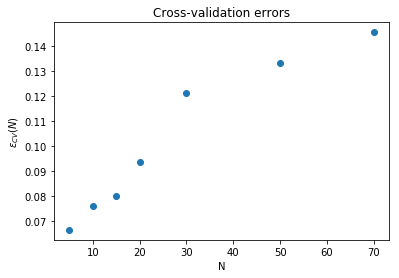

Number of folds is: 10
Optimal N is: 5


In [41]:
V = 10
errors = [err_cv(N, V, X, Y) for N in Ns]
N_opt = Ns[np.argmin(errors)]
plt.plot(Ns, errors,'o')
plt.title("Cross-validation errors")
plt.xlabel("N")
plt.ylabel("$\epsilon_{CV}(N)$")
plt.show()
print("Number of folds is: " + str(V) + "\nOptimal N is: " + str(N_opt))

For this specific sample the optimal smoothing parameter $N_{CV}$ turned out to equal 5. This corresponds to our intuition and the suggestion about optimal N we made observing the plots (N~5-10).

However, clearly, the optimal $N_{CV}$ depends on the realizations of $X$ and $\xi$, hence is a random number. We conduct an experiment simulating samples of $X$ and $\xi$ 200 times and calculate $N_{CV}$ for each simulation. Finally, we plot a histogram of $N_{CV}$.

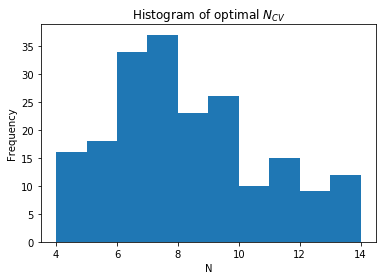

In [29]:
def Ns_opt (V):
    X = np.random.uniform(0, 1, 100)
    Ksi = np.random.normal(0, 1, 100)
    Y = f(X) + sigma*Ksi
    errors = [err_cv(N, V, X, Y) for N in Ns]
    N_opt = Ns[np.argmin(errors)]
    return N_opt
V = 10
Ns_opt = np.array([Ns_opt(V) for i in np.arange(200)])
plt.hist(Ns_opt)
plt.title("Histogram of optimal $N_{CV}$")
plt.xlabel("N")
plt.ylabel("Frequency")
plt.show()
plt.show()

As the resulting histogram shows, the optimal $N_{CV}$ are concentrated around 10. During this simulation $N$ never happened to be larger than 20. 

<br> It's interesiting to look closer at the values of $N$ from 2 to 15. Intuition says, the distribution of optimal $N$ must be unimodal with moderate variance.
<br> Let's examine this issue.

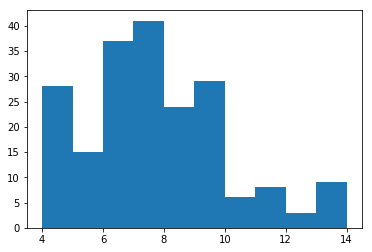

In [28]:
def Ns_opt (V):
    X = np.random.uniform(0, 1, 100)
    Ksi = np.random.normal(0, 1, 100)
    Y = f(X) + sigma*Ksi
    errors = [err_cv(N, V, X, Y) for N in Ns]
    N_opt = Ns[np.argmin(errors)]
    return N_opt
Ns = range(2,15)
Ns_opt = np.array([Ns_opt(V) for i in np.arange(200)])
plt.hist(Ns_opt)
plt.title("Histogram of optimal $N_{CV}$")
plt.xlabel("N")
plt.ylabel("Frequency")
plt.show()

__Conclusion__
We see that noisy function $Y$ of a random variable $X$ can be well projected onto the Fourier basis. The plots of estimator and groud truth function turned out to be very close for particular (namely, moderate) values of $N$.

<br>The right choice of smoothing parameter $N$ is crucial for projection estimation. High values of $N$ lead to extreme overfitting and highly oscillating estamators, whereas too low values of $N$ lead to underfitting and high bias. 

<br>Cross-validation is a helpful technique to select optimal model. In our case it turned out that optimal number of functions in the Fourier basis is concentrated around 7 (when closer look is taken). 

#### Exercise 2. Real data

Now, we exploit the methodology suggested above to estimating the regression function on the real-world data.
<br> We have chosen records on pneumonia and influenza mortality in the U.S. as our dataset.
<br> Data is available at https://data.cdc.gov/dataset/Deaths-in-122-U-S-cities-1962-2016-122-Cities-Mort/mr8w-325u/data providing advanced statistics on deaths in 122 U.S. cities. 
<br>
We are examining 156 records of deaths percentage from pneumonia and influenza (out of all deaths) during four consecutive years from 2009 to 2011 on the weekly basis. Thus, in our dataset $X_i, i=1,...,256$ is the _week number_ and $Y_i$ is the percentage of deaths from pneumonia and influenza at the end of week $X_i$.

Final dataset after preprocessing can be found at https://github.com/maxberezov/Projects/blob/master/pneum-2.csv

<br>_Remark_
<br>It should be noted that, unlike $X_i$ in Exercise 1, in our dataset $X_i$ are not random (as time points in time series). However, this is not the problem. After scaling of $X_i$ (so that $X$ ranges from 0 to 1), we can treat our case as a _regular design_ case we discussed during the lectures. Moreover, intrinsically periodic time series data is the most suitable for projection onto trigonometric basis due to periodicity of basis functions.

In [87]:
import pandas as pd
data = pd.read_csv('pneum.csv')

Let's take a look at our data.

In [89]:
data[:10] # first 10 samples

,Year,WEEK,Pneumonia.And.Influenza.Deaths,Percentage
1,2009,1,1030,6.977374
2,2009,2,1014,7.605190
3,2009,3,899,7.091024
4,2009,4,923,6.980790
5,2009,5,911,7.177750
6,2009,6,890,6.876304
7,2009,7,875,7.494005
8,2009,8,935,7.337362
9,2009,9,926,7.456317
10,2009,10,875,7.128890


As discussed, for the analysis we will use only 'Percentage' column, and we will generate the vector of time points from 1 to 156 corresponding to the number of week.

In [90]:
Y = data['Percentage'] # Percentage - target variable, Y
X = np.linspace(1, len(Y), len(Y)) # Week number - feature, X

We normalize $X$ using MinMaxScaler tool from sklearn package so that $X$ ranges from 0 to 1.

In [92]:
from sklearn import preprocessing 
scaler = preprocessing.MinMaxScaler() #scaler to normalize our data
X = X.reshape(-1,1)
X = scaler.fit_transform(X)
X = X.reshape(-1)

Let's visualize our data and see which patterns it follow.

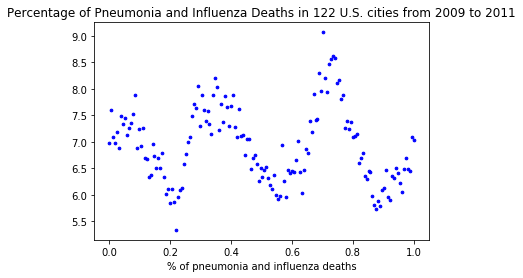

In [103]:
plt.plot(X,Y,'bo',ms=2.7)
plt.title("Percentage of Pneumonia and Influenza Deaths in 122 U.S. cities from 2009 to 2011")
plt.xlabel("Number of week")
plt.xlabel("% of pneumonia and influenza deaths")
plt.show()
x_grid = np.linspace(min(X), max(X), 300)

Notice that percentage of pneumonia and influenza deaths is quite high ranging from around 5.5% to >9.0% and is intrinsically periodic. As we know, pneumonia and influenza thrive during the autumn-winter season and people suffer from these diseas much less during spring and summer. Consequently, people die from pneumonia and influenza more or less according to the season. Hence, the peaks in our graph occur during autumn and winter months. The pattern repeats over the years.
<br> Moreover, we can observe an increasing trend in percentage of deaths: the peaks become higher and higher. 

<br> Now, let us project our data onto Fourier basis and look at the plots of the estimators.

N = 2


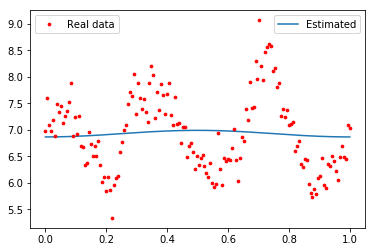

N = 5


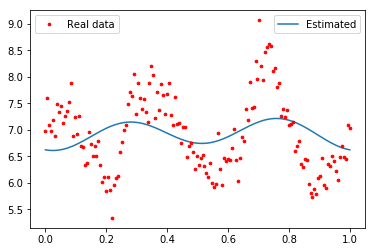

N = 10


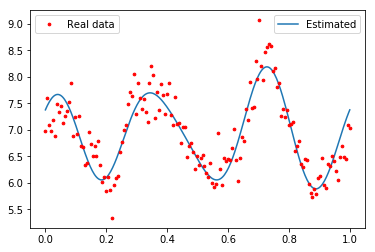

N = 15


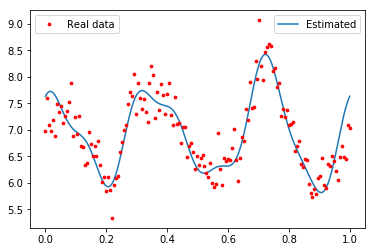

N = 20


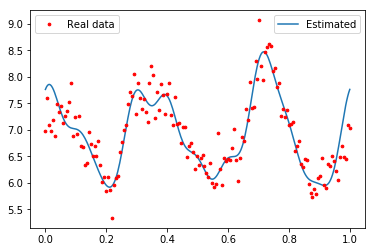

N = 30


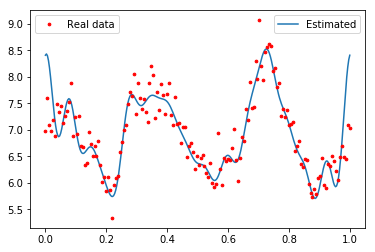

N = 50


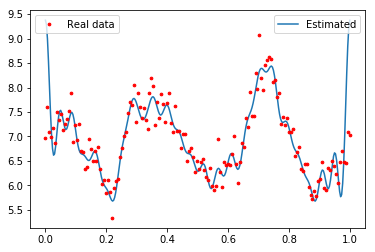

N = 70


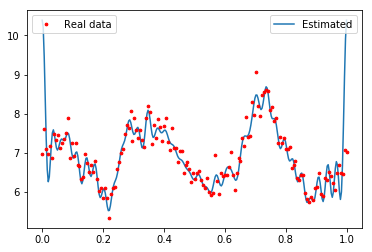

In [105]:
Ns = [2,5,10,15,20,30,50,70]
for N in Ns:
    fN_hat = f_hat(N, x_grid, X, Y)
    line1, = plt.plot(x_grid, fN_hat,label="Estimated")
    line2, = plt.plot(X, Y,'ro' , ms = 2.7, label="Real data")
    first_legend = plt.legend(handles=[line1], loc=1)
    ax = plt.gca().add_artist(first_legend)
    second_legend = plt.legend(handles=[line2], loc=2)
    print('N = ' + str(N))
    plt.show()

Perfect!
<br> From the plots above, we see that data can be very well approximated by projection estimator when the number of basis functions is 10-15. $N = 2$ and $N = 5$ lead to underfitting, whereas overfitting occurs when $N > 30$.

<br> Let's check our suggestion using cross-validation.

Optimal N is: 15


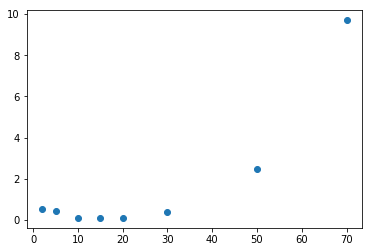

In [106]:
V = 10
errors = [err_cv(N, V, X, Y) for N in Ns]
N_opt = Ns[np.argmin(errors)]
print("Optimal N is: " + str(N_opt))
plt.plot(Ns, errors,'o')
plt.show()

As expected, cross-validation error is the lowest when $N$ is around 15 ($N = 10$ and $N = 20$) also deliver low levels of CV-error.

Plotting estimator with optimal N

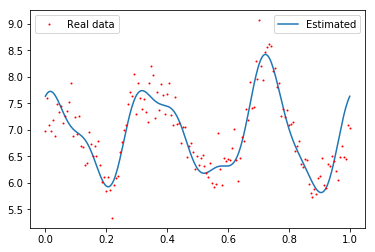

In [99]:
fN_hat = f_hat(N_opt, x_grid, X, Y)
line1, = plt.plot(x_grid, fN_hat,label="Estimated")
line2, = plt.plot(X, Y,'ro' , ms = 1, label="Real data")
first_legend = plt.legend(handles=[line1], loc=1)
ax = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=[line2], loc=2)
plt.show()

__Conclusion__

As we can see, estimator captures the general trends in the dataset good enough. We conclude it's suitable for time-series data that do not tend to increase with time. Optimal solution does not require huge value of basis function.